# Rate Prediction of Syngas Fermentation for Feed-Forward Process Control

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import sklearn
import sklearn.neural_network
import sklearn.svm
import sklearn.ensemble
import matplotlib.pyplot as plt
import scipy

## Get Starting Data
This data was generated from the data processing notebook

In [2]:
home_dir = os.getcwd().split('/notebooks')[0]
sys.path.append(home_dir)
home_dir
smooth_data = pd.read_csv(f'{home_dir}/processed_data/smooth_data.csv')
smooth_data.set_index(['composition','trial','time'], drop=True, inplace=True)
print(f'Shape of the smooth data: {smooth_data.shape[0]} rows by {smooth_data.shape[1]} columns')

Shape of the smooth data: 856 rows by 24 columns


## Create train/test sets (Changed from original train/test)
New: <br>
Training data comes from compostions 1-5, 9, 10.<br>
Test data comes from compostions 6, 7, and 8.
<br>
<br>
Old: <br>
Training data comes from compostions 1-7.<br>
Test data comes from compostions 8, 9, and 10.

In [3]:
train_validation_data = smooth_data.loc[[1,2,3,4,5,9,10]]
print(f'Shape of the train_validation data: {train_validation_data.shape[0]} rows by {train_validation_data.shape[1]} columns')
test_data = smooth_data.loc[[6,7,9]]
print(f'Shape of the test data: {test_data.shape[0]} rows by {test_data.shape[1]} columns')

Shape of the train_validation data: 686 rows by 24 columns
Shape of the test data: 170 rows by 24 columns


## Define a function that generates the X array and y array for ML model training

The parameter 'input_data' is used to specify whether raw data or the polynomial smoothed data will be used to train the model <br>
The parameter 'conditions_to_include' is a list of the conditions to include in the returned arrays

In [4]:
def get_X_y_arrays(data):

    data_copy = data.copy()
    data_copy.reset_index(inplace=True)
    X = data_copy [['acetate', 'biomass', 'butanol', 'butyrate', 'ethanol', 'CO', 'CO2', 'H2', 'flow rate']]
    y = data_copy [['acetate_Δ', 'biomass_Δ', 'butanol_Δ', 'butyrate_Δ', 'ethanol_Δ']]
 
    return np.array(X), np.array(y)

In [5]:
X_train_validation, y_train_validation = get_X_y_arrays(train_validation_data)
X_test, y_test = get_X_y_arrays(test_data)

print(f'Shape of the train_validation X array: {X_train_validation.shape[0]} rows by {X_train_validation.shape[1]} columns')
print(f'Shape of the train_validation y array: {y_train_validation.shape[0]} rows by {y_train_validation.shape[1]} columns')
print(f'Shape of the test X array: {X_test.shape[0]} rows by {X_test.shape[1]} columns')
print(f'Shape of the test y array: {y_test.shape[0]} rows by {y_test.shape[1]} columns')

Shape of the train_validation X array: 686 rows by 9 columns
Shape of the train_validation y array: 686 rows by 5 columns
Shape of the test X array: 170 rows by 9 columns
Shape of the test y array: 170 rows by 5 columns


### Define a dictionary of models with optimized parameters
This hyperparameters in models in this dictionary were found using a gridsearch with suffle split separation of training an validation data. The test data was not used in the training of these models.

In [6]:
optimized_models = {
    "acetate": {
        "nn": sklearn.neural_network.MLPRegressor(
            shuffle=True, 
            activation = 'relu', 
            hidden_layer_sizes = [100, 100, 60, 100],
            max_iter = 5000
        ),
        "svm_rbf": sklearn.svm.SVR(
            kernel = 'rbf', 
            C = 10000, 
            epsilon = 0.1, 
            gamma = 10
        ),
        'rf': sklearn.ensemble.RandomForestRegressor(
            max_depth = 36,
#             max_samples = 0.5,
            n_estimators = 110
        ),
        'en': sklearn.linear_model.ElasticNet(
            alpha =  0.1,
            l1_ratio = 1.0
        ),
        'lasso': sklearn.linear_model.Lasso(
            alpha = 0.1
        ),
#         'gauss': sklearn.gaussian_process.GaussianProcessRegressor(
#             alpha =  1e-10
#         ),
        'knn': sklearn.neighbors.KNeighborsRegressor(
            algorithm = 'ball_tree',
            leaf_size = 5,
            n_neighbors = 2,
            weights = 'distance'
        ),
    },
    "biomass": {
        "nn": sklearn.neural_network.MLPRegressor(
            shuffle=True, 
            activation = 'relu', 
            hidden_layer_sizes = [100, 100, 100, 100],
            max_iter = 5000
        ),
        "svm_rbf": sklearn.svm.SVR(
            kernel = 'rbf', 
            C = 100, 
            epsilon = 0.01, 
            gamma = 100
        ),
        'rf': sklearn.ensemble.RandomForestRegressor(
            max_depth = 14,
#             max_samples = 0.5,
            n_estimators = 50
        ),
        'en': sklearn.linear_model.ElasticNet(
            alpha =  0.0001,
            l1_ratio = 1.0
        ),
        'lasso': sklearn.linear_model.Lasso(
            alpha = 0.0001
        ),
#         'gauss': sklearn.gaussian_process.GaussianProcessRegressor(
#             alpha =  1e-7
#         ),
        'knn': sklearn.neighbors.KNeighborsRegressor(
            algorithm = 'ball_tree',
            leaf_size = 5,
            n_neighbors = 2,
            weights = 'distance'
        ),
    },
    "butanol": {
        "nn": sklearn.neural_network.MLPRegressor(
            shuffle=True, 
            activation = 'relu', 
            hidden_layer_sizes = [60, 40, 80, 60],
            max_iter = 5000
        ),
        "svm_rbf": sklearn.svm.SVR(
            kernel = 'rbf', 
            C = 10000, 
            epsilon = 0.01, 
            gamma = 10
        ),
        'rf': sklearn.ensemble.RandomForestRegressor(
            max_depth = 24,
#             max_samples = 0.5,
            n_estimators = 90
        ),
        'en': sklearn.linear_model.ElasticNet(
            alpha =  0.001,
            l1_ratio = 0.1
        ),
        'lasso': sklearn.linear_model.Lasso(
            alpha = 1e-10
        ),
#         'gauss': sklearn.gaussian_process.GaussianProcessRegressor(
#             alpha =  1e-8
#         ),
        'knn': sklearn.neighbors.KNeighborsRegressor(
            algorithm = 'ball_tree',
            leaf_size = 5,
            n_neighbors = 2,
            weights = 'distance'
        ),
    },
    "butyrate": {
        "nn": sklearn.neural_network.MLPRegressor(
            shuffle=True, 
            activation = 'relu', 
            hidden_layer_sizes = [40, 40, 40, 40],
            max_iter = 5000
        ),
        "svm_rbf": sklearn.svm.SVR(
            kernel = 'rbf', 
            C = 10000, 
            epsilon = 0.01, 
            gamma = 10
        ),
        'rf': sklearn.ensemble.RandomForestRegressor(
            max_depth = 28,
#             max_samples = 0.5,
            n_estimators = 140
        ),
        'en': sklearn.linear_model.ElasticNet(
            alpha =  0.001,
            l1_ratio = 0.1
        ),
        'lasso': sklearn.linear_model.Lasso(
            alpha = 0.01
        ),
#         'gauss': sklearn.gaussian_process.GaussianProcessRegressor(
#             alpha =  1e-8
#         ),
        'knn': sklearn.neighbors.KNeighborsRegressor(
            algorithm = 'ball_tree',
            leaf_size = 5,
            n_neighbors = 2,
            weights = 'distance'
        ),
    },
    "ethanol": {
        "nn": sklearn.neural_network.MLPRegressor(
            shuffle=True, 
            activation = 'tanh', 
            hidden_layer_sizes = [80, 80, 40, 100],
            max_iter = 5000
        ),
        "svm_rbf": sklearn.svm.SVR(
            kernel = 'rbf', 
            C = 10000, 
            epsilon = 0.1, 
            gamma = 10
        ),
        'rf': sklearn.ensemble.RandomForestRegressor(
            max_depth = 24,
#             max_samples = 0.5,
            n_estimators = 120
        ),
        'en': sklearn.linear_model.ElasticNet(
            alpha =  0.001,
            l1_ratio = 0.2
        ),
        'lasso': sklearn.linear_model.Lasso(
            alpha = 0.01
        ),
# My version of sklearn doesn't have gaussian process
#         'gauss': sklearn.gaussian_process.GaussianProcessRegressor(
#             alpha =  1e-8
#         ),
        'knn': sklearn.neighbors.KNeighborsRegressor(
            algorithm = 'ball_tree',
            leaf_size = 5,
            n_neighbors = 3,
            weights = 'distance'
        ),
    },
}
    


### Get the predictions of the models on the training set and test set

In [7]:
# Make a dictionary to save trained models 
trained_models = {}

# Define two dictionaries to hold data for training and test data
model_train_output_dictionary = {}
model_test_output_dictionary = {}

# Scale both sets of X data
Scaler = sklearn.preprocessing.MinMaxScaler()
X_scaled_train = Scaler.fit_transform(X_train_validation, y_test)
X_scaled_test = Scaler.fit_transform(X_test, y_test)

for index, output in enumerate(['acetate', 'biomass', 'butanol', 'butyrate', 'ethanol']):
    
    # separate out the output of interest
    y_train_output=y_train_validation[:,index]
    y_test_output=y_test[:,index]
    
    # save the measured data in the output dictionaries
    model_train_output_dictionary[f'{output} measured'] = y_train_output
    model_test_output_dictionary[f'{output} measured'] = y_test_output
    
    for algorithm in ['nn', 'svm_rbf', 'rf', 'en', 'lasso', 'knn']:
        print(output, algorithm)

        # train the model and save it
        trained_model = optimized_models[output][algorithm].fit(X_scaled_train, y_train_output)
        trained_models[f'{output} {algorithm}'] = trained_model
        
        # test the model on training and test data
        y_train_prediction = trained_model.predict(X_scaled_train)
        y_test_prediction = trained_model.predict(X_scaled_test)
        
        # save the outputs in dictionaries
        model_train_output_dictionary[f'{output} {algorithm}'] = y_train_prediction
        model_test_output_dictionary[f'{output} {algorithm}'] = y_test_prediction
        
# convert the dictionaries to dataframes
train_prediction_df = pd.DataFrame(model_train_output_dictionary)
test_prediction_df = pd.DataFrame(model_test_output_dictionary)

# display the data frames
display(train_prediction_df.head())
display(test_prediction_df.head())

acetate nn
acetate svm_rbf
acetate rf
acetate en
acetate lasso
acetate knn
biomass nn
biomass svm_rbf
biomass rf
biomass en
biomass lasso
biomass knn
butanol nn
butanol svm_rbf
butanol rf
butanol en
butanol lasso
butanol knn
butyrate nn


/usr/local/share/jupyteruser/.pyenv/versions/biod_3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 729.3586776377302, tolerance: 0.41090038155867326
  positive)


butyrate svm_rbf
butyrate rf
butyrate en
butyrate lasso
butyrate knn
ethanol nn
ethanol svm_rbf
ethanol rf
ethanol en
ethanol lasso
ethanol knn


,acetate measured,acetate nn,acetate svm_rbf,acetate rf,acetate en,acetate lasso,acetate knn,biomass measured,biomass nn,biomass svm_rbf,...,butyrate en,butyrate lasso,butyrate knn,ethanol measured,ethanol nn,ethanol svm_rbf,ethanol rf,ethanol en,ethanol lasso,ethanol knn
0,18.298778,20.375636,15.982144,21.106771,21.764804,21.764804,18.298778,-0.102733,-0.023235,-0.093607,...,0.838762,1.037497,-0.100208,-4.628878,-5.685227,-4.729028,-5.447387,1.863000,1.819169,-4.628878
1,23.651756,27.700282,23.772965,25.856633,21.696372,21.696372,23.651756,-0.072009,-0.018957,-0.061736,...,0.903359,1.100206,-0.006462,-6.218271,-5.859535,-5.570619,-6.028436,2.123085,2.067530,-6.218271
2,30.976760,35.346571,31.075453,32.723636,21.402566,21.402566,30.976760,0.001068,-0.010902,-0.009222,...,0.987124,1.184351,-0.148525,-5.662923,-5.880789,-5.847267,-5.707900,2.611306,2.542513,-5.662923
3,37.112317,41.940168,36.642468,38.142577,20.949983,20.949983,37.112317,0.025050,0.000876,0.026376,...,1.090608,1.287957,0.056090,-6.339674,-5.787963,-6.240440,-6.199862,3.224182,3.140901,-6.339674
4,38.941765,45.928127,38.843057,40.541393,20.380329,20.380329,38.941765,0.046344,0.012928,0.036077,...,1.202659,1.399516,0.400977,-6.738344,-5.583522,-6.518442,-6.448362,3.878177,3.780934,-6.738344


,acetate measured,acetate nn,acetate svm_rbf,acetate rf,acetate en,acetate lasso,acetate knn,biomass measured,biomass nn,biomass svm_rbf,...,butyrate en,butyrate lasso,butyrate knn,ethanol measured,ethanol nn,ethanol svm_rbf,ethanol rf,ethanol en,ethanol lasso,ethanol knn
0,14.583738,27.987798,5.816728,21.266459,32.545275,32.545275,18.202588,-0.121077,-0.107460,0.039848,...,-0.187061,0.076960,0.474339,-0.065765,-13.751290,7.505557,-4.724056,-9.548327,-9.730729,0.222718
1,14.096986,29.910678,5.814273,22.479824,32.105476,32.105476,18.212025,-0.104489,-0.102480,0.039848,...,-0.097305,0.157899,1.171322,-0.264371,-13.903423,7.448280,-4.833602,-9.174583,-9.362004,0.220364
2,14.595566,31.284665,5.809134,24.357677,31.455437,31.455437,17.758639,-0.057475,-0.096246,0.039848,...,0.003739,0.249047,2.016852,-0.039249,-14.081352,7.421063,-4.873065,-8.741749,-8.931429,-1.297784
3,14.680697,32.149880,5.803648,22.492366,30.673924,30.673924,17.625311,-0.042796,-0.089789,0.039848,...,0.115597,0.348742,2.978607,-0.515511,-14.334245,7.415211,-5.158528,-8.320560,-8.510015,-1.655615
4,14.622751,32.346197,5.799609,23.119444,29.754014,29.754014,17.860191,-0.026833,-0.081885,0.039848,...,0.238397,0.456928,4.016450,-1.045213,-14.702204,7.422933,-5.538579,-7.917789,-8.104247,-1.858805


### Save dataframes as .csv for excel based figures

In [10]:
train_prediction_df.to_csv('../prediction_data/train_predictions.csv')
test_prediction_df.to_csv('../prediction_data/test_predictions.csv')

### Plot scatter plots of fits

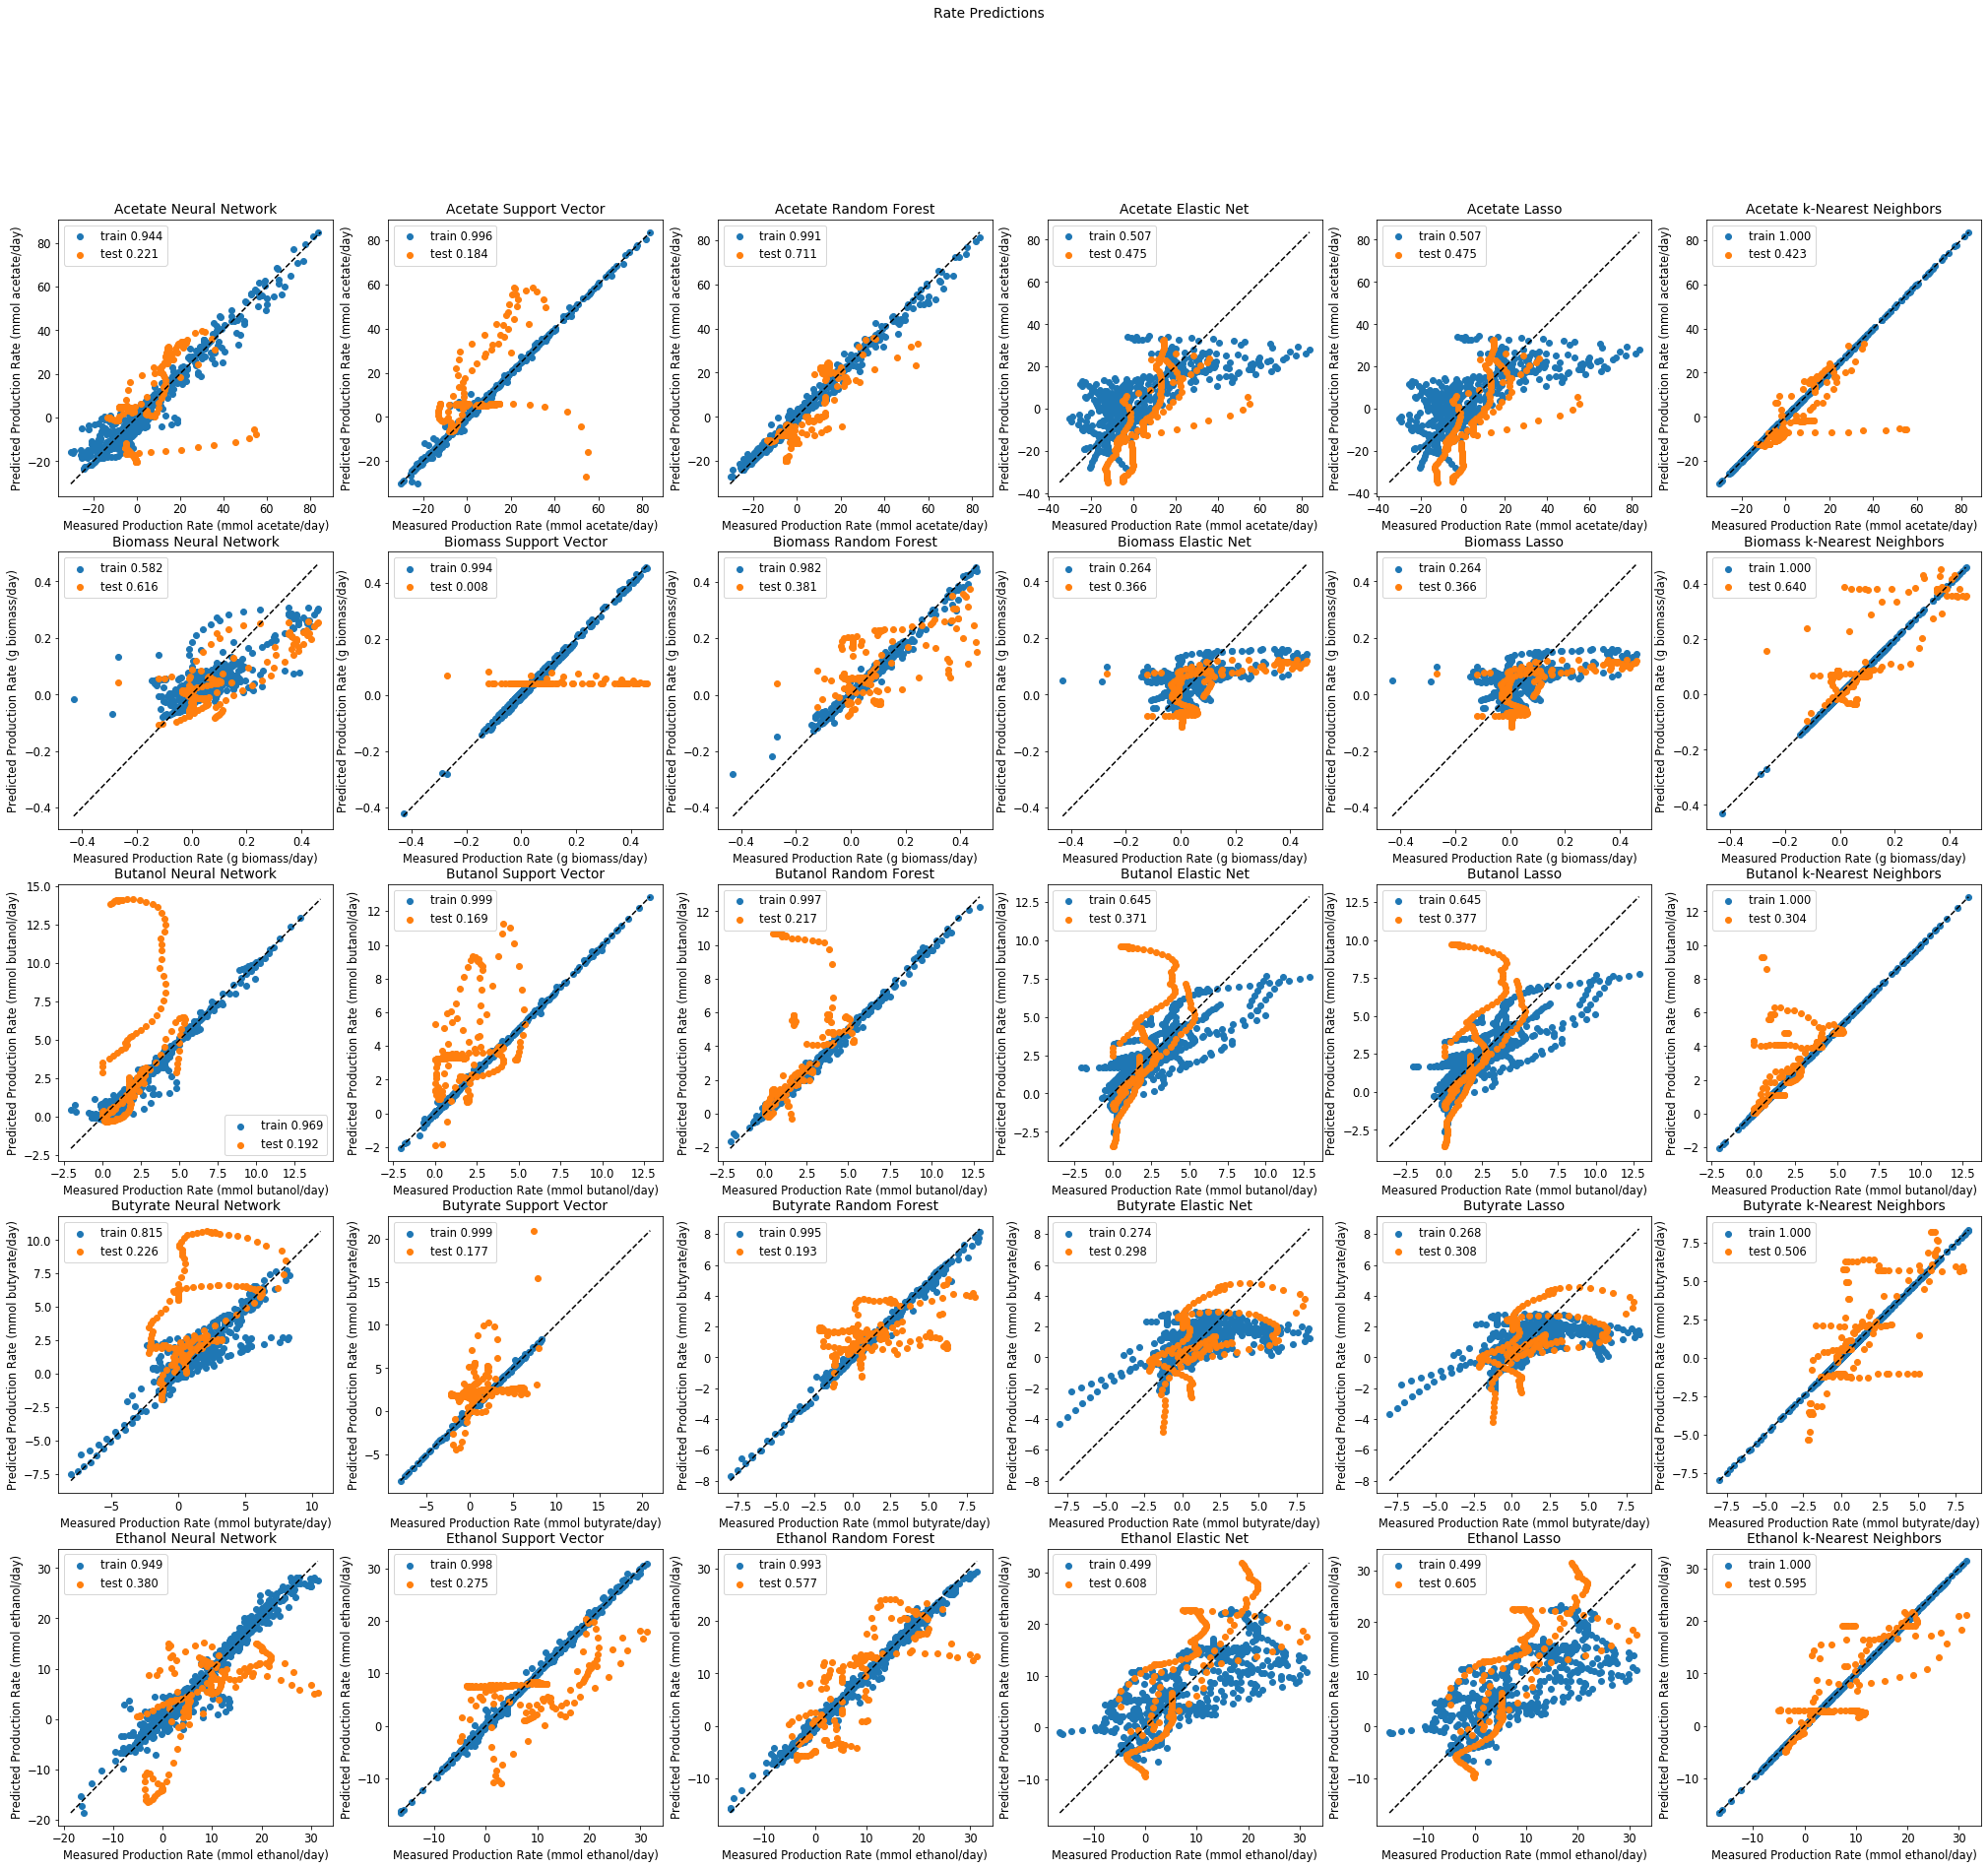

In [11]:
plt.rcParams.update({'font.size': 11.5})
fig, ax = plt.subplots(5, 6, figsize=(35, 30))
fig.suptitle(f'Rate Predictions')

algorithm_dictionary = {
    'nn': 'Neural Network',
    'svm_rbf': 'Support Vector', 
    'rf' : 'Random Forest',
    'en': 'Elastic Net', 
    'lasso' : 'Lasso',
    'knn': 'k-Nearest Neighbors'
}

for x_index, output in enumerate(['acetate', 'biomass', 'butanol', 'butyrate', 'ethanol']):
    train_r2_list = []
    test_r2_list = []
    for y_index, algorithm in enumerate(['nn', 'svm_rbf', 'rf', 'en', 'lasso', 'knn']):
 
        # Set title, x label, and y label of the subplot
        ax[x_index, y_index].title.set_text(f'{output.capitalize()} {algorithm_dictionary[algorithm]}')
        if output != 'biomass':
            ax[x_index, y_index].set_xlabel(f'Measured Production Rate (mmol {output}/day)')
            ax[x_index, y_index].set_ylabel(f'Predicted Production Rate (mmol {output}/day)')
        else:
            ax[x_index, y_index].set_xlabel(f'Measured Production Rate (g biomass/day)')
            ax[x_index, y_index].set_ylabel(f'Predicted Production Rate (g biomass/day)')
            
        # Plot training and test data by plotting predicted Production Rates vs measured Production Rates
        ax[x_index, y_index].scatter(train_prediction_df[f'{output} measured'], train_prediction_df[f'{output} {algorithm}'])
        ax[x_index, y_index].scatter(test_prediction_df[f'{output} measured'], test_prediction_df[f'{output} {algorithm}'])
        
        # ensure that all plots are square, so that 45 degree line looks the same in all plots
        minimum = min(pd.concat([
            train_prediction_df[f'{output} measured'],
            train_prediction_df[f'{output} {algorithm}'],
            test_prediction_df[f'{output} measured'],
            test_prediction_df[f'{output} {algorithm}']
        ], axis=0))
        maximum = max(pd.concat([
            train_prediction_df[f'{output} measured'],
            train_prediction_df[f'{output} {algorithm}'],
            test_prediction_df[f'{output} measured'],
            test_prediction_df[f'{output} {algorithm}']
        ], axis=0))
        
        # calculate train data r-squared
        measured_train_data = train_prediction_df[f'{output} measured']
        predicted_train_data = train_prediction_df[f'{output} {algorithm}']
        # could use scikitlearn's r-squared value
        # train_r2 = sklearn.metrics.r2_score(measured_train_data, predicted_train_data)
        _, _, train_r_value, _, _ = scipy.stats.linregress(measured_train_data, predicted_train_data)
        train_r2_list.append(train_r_value**2)

        # calculate test data r-squared
        measured_test_data = test_prediction_df[f'{output} measured']
        predicted_test_data = test_prediction_df[f'{output} {algorithm}']
        # could use scikitlearn's r-squared value
        # test_r2 = sklearn.metrics.r2_score(measured_test_data, predicted_test_data)
        _, _, test_r_value, _, _ = scipy.stats.linregress(measured_test_data, predicted_test_data)
        test_r2_list.append(test_r_value**2)
        
        # add legend to the plot
        ax[x_index, y_index].legend([f'train {train_r_value**2:.3f}', f'test {test_r_value**2:.3f}'])
        
        # plot the subplot
        ax[x_index, y_index].plot([minimum, maximum], [minimum, maximum], 'k--') #row=0, col=0

plt.savefig(f'{home_dir}/final_figures/scatter_plots.png', dpi=100)
plt.show()

### Plot bar graph of r squared values

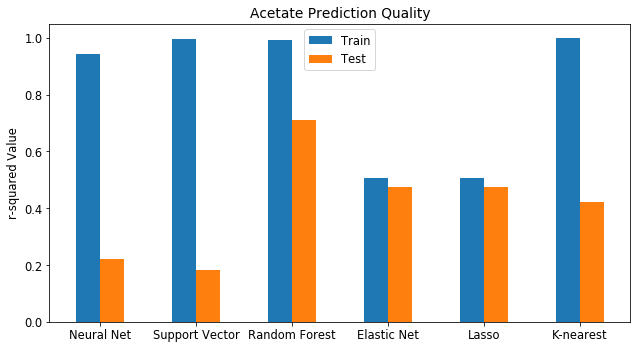

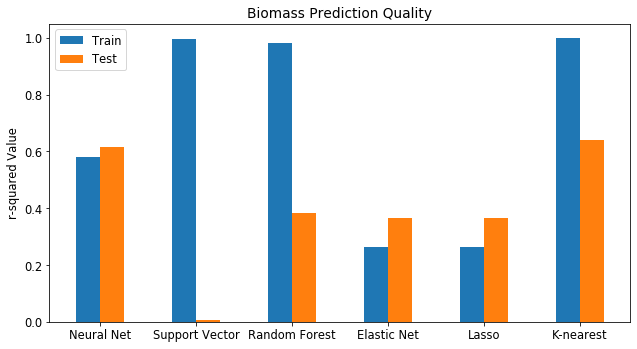

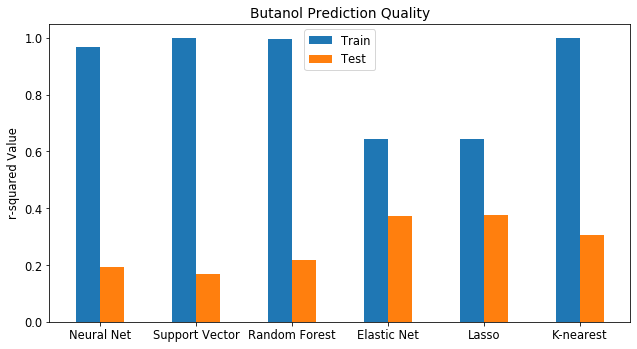

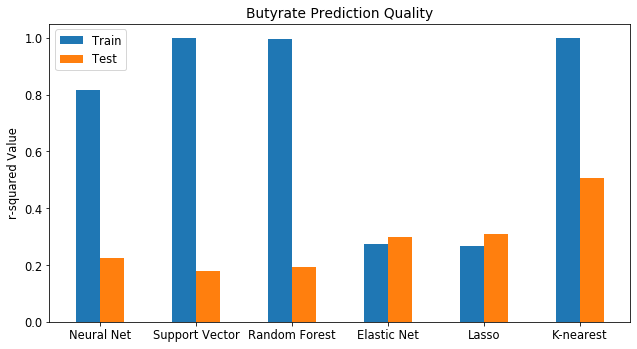

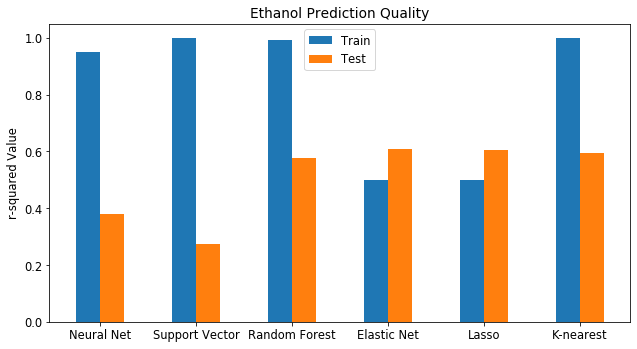

In [12]:
plt.rcParams.update({'font.size': 11.5})
for output in ['acetate', 'biomass', 'butanol', 'butyrate', 'ethanol']:
    train_r2_list = []
    test_r2_list = []
    for algorithm in ['nn', 'svm_rbf', 'rf', 'en', 'lasso', 'knn']:

        # Calculate training data r-squared
        measured_train_data = train_prediction_df[f'{output} measured']
        predicted_train_data = train_prediction_df[f'{output} {algorithm}']
        # could use scikitlearn's r-squared value
        # train_r2 = sklearn.metrics.r2_score(measured_train_data, predicted_train_data)
        _, _, train_r_value, _, _ = scipy.stats.linregress(measured_train_data, predicted_train_data)
        train_r2_list.append(train_r_value**2)

        # Calculate test data r-squared
        measured_test_data = test_prediction_df[f'{output} measured']
        predicted_test_data = test_prediction_df[f'{output} {algorithm}']
        # could use scikitlearn's r-squared value
        # test_r2 = sklearn.metrics.r2_score(measured_test_data, predicted_test_data)
        _, _, test_r_value, _, _ = scipy.stats.linregress(measured_test_data, predicted_test_data)
        test_r2_list.append(test_r_value**2)
    
    # define values to help with plotting
    x = np.arange(6)  # the label locations
    width = 0.25  # the width of the bars

    # plot training and testing r-squared values
    fig, ax = plt.subplots(figsize=(9,5))
    rects1 = ax.bar(x - .5 * width, train_r2_list,      width, label='Train')
    rects3 = ax.bar(x + .5 * width, test_r2_list, width, label='Test')

    # Add labels for title and custom x-axis tick labels, etc.
    ax.set_ylabel('r-squared Value')
    ax.set_title(f'{output.capitalize()} Prediction Quality')
    ax.set_xticks(x)
    ax.set_xticklabels(['Neural Net', 'Support Vector', 'Random Forest', 'Elastic Net', 'Lasso', 'K-nearest'])
    ax.legend()

    fig.tight_layout()
    plt.savefig(f'{home_dir}/final_figures/bar_graph_{output}.png', dpi=100)
#     plt.show()

### Make data frames to plot feature importance of metabolite and gases

In [13]:
features = ['acetate', 'biomass', 'butanol', 'butyrate', 'ethanol', 'CO', 'CO2', 'H2', 'flow rate']

metabolites = ['acetate', 'biomass', 'butanol', 'butyrate', 'ethanol']
gases = ['CO', 'CO2', 'H2', 'flow rate']

metabolite_feature_importance_list = []
gases_feature_importance_list = []

for output in ['acetate', 'biomass', 'butanol', 'butyrate', 'ethanol']:
    
    # get trained random forest model for the output
    model = trained_models[f'{output} rf']
    
    # get feature importance
    feature_importance_array = model.feature_importances_
    # print(feature_importance_array)
    
    # label feature importances
    feature_importance_dictionary = {feature: importance for feature, importance in zip(features, feature_importance_array)}
    
    # split dictionary into metabolites and gases and add the split dictionaries to lists
    metabolite_feature_importance_list.append({metabolite: feature_importance_dictionary[metabolite] for metabolite in metabolites})
    gases_feature_importance_list.append({gas: feature_importance_dictionary[gas] for gas in gases})
    
# convert list of dictionaries to dataframes
metabolite_feature_importance_df = pd.DataFrame(metabolite_feature_importance_list, index=metabolites)
gases_feature_importance_df = pd.DataFrame(gases_feature_importance_list, index=metabolites)

# display the dataframes
display(metabolite_feature_importance_df)
display(gases_feature_importance_df)


,acetate,biomass,butanol,butyrate,ethanol
acetate,0.112158,0.052105,0.642240,0.094738,0.055331
biomass,0.185968,0.348861,0.208368,0.085500,0.119181
butanol,0.036654,0.081757,0.597754,0.049544,0.052346
butyrate,0.214162,0.131434,0.241585,0.139723,0.162288
ethanol,0.066777,0.159770,0.086918,0.122051,0.532477


,CO,CO2,H2,flow rate
acetate,0.002672,0.017416,0.003560,0.019780
biomass,0.011618,0.006303,0.015162,0.019038
butanol,0.053648,0.053600,0.058070,0.016628
butyrate,0.041940,0.020274,0.044153,0.004442
ethanol,0.005734,0.009482,0.006399,0.010391


### Plot metabolite feature importance

,acetate,biomass,butanol,butyrate,ethanol
acetate,0.112158,0.052105,0.642240,0.094738,0.055331
biomass,0.185968,0.348861,0.208368,0.085500,0.119181
butanol,0.036654,0.081757,0.597754,0.049544,0.052346
butyrate,0.214162,0.131434,0.241585,0.139723,0.162288
ethanol,0.066777,0.159770,0.086918,0.122051,0.532477


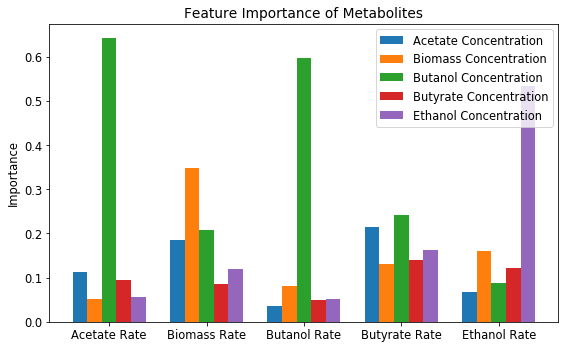

In [14]:
display(metabolite_feature_importance_df)

# This helps with formatting 
x = np.arange(5)  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(8,5))

for counter, (index, row) in enumerate(metabolite_feature_importance_df.transpose().iterrows()):
    output_feature_importances = list(row)
    
    rects = ax.bar(x - 0.3 + 0.15*counter, output_feature_importances , width, label=f'{index.capitalize()} Concentration')

# # Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(f'Importance')

ax.set_title(f'Feature Importance of Metabolites')
ax.set_xticks(x)
labels = ['Acetate Rate', 'Biomass Rate', 'Butanol Rate', 'Butyrate Rate', 'Ethanol Rate']
ax.set_xticklabels(labels)
ax.legend()
# ax.set_yscale('log')

fig.tight_layout()
plt.savefig(f'{home_dir}/final_figures/feature_importance_metabolites.png', dpi=100)
plt.show()

### Plot gases feature importance

,CO,CO2,H2,flow rate
acetate,0.002672,0.017416,0.003560,0.019780
biomass,0.011618,0.006303,0.015162,0.019038
butanol,0.053648,0.053600,0.058070,0.016628
butyrate,0.041940,0.020274,0.044153,0.004442
ethanol,0.005734,0.009482,0.006399,0.010391


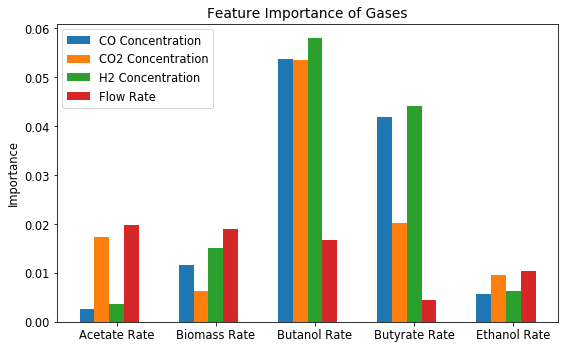

In [15]:
display(gases_feature_importance_df)

# This helps with formatting 
x = np.arange(5)  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(8,5))

for counter, (index, row) in enumerate(gases_feature_importance_df.transpose().iterrows()):
    output_feature_importances = list(row)
    if index != 'flow rate':
        index = index + ' Concentration' 
    else:
        index = 'Flow Rate'
    rects = ax.bar(x - 0.3 + 0.15*counter, output_feature_importances , width, label=f'{index}')

# # Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(f'Importance')

ax.set_title(f'Feature Importance of Gases')
ax.set_xticks(x)
labels = ['Acetate Rate', 'Biomass Rate', 'Butanol Rate', 'Butyrate Rate', 'Ethanol Rate']
ax.set_xticklabels(labels)
ax.legend()
# ax.set_yscale('log')

fig.tight_layout()
plt.savefig(f'{home_dir}/final_figures/feature_importance_gases.png', dpi=100)
plt.show()

### Plot feature importance of each gas for each output

,CO,CO2,H2,flow rate
acetate,0.002672,0.017416,0.003560,0.019780
biomass,0.011618,0.006303,0.015162,0.019038
butanol,0.053648,0.053600,0.058070,0.016628
butyrate,0.041940,0.020274,0.044153,0.004442
ethanol,0.005734,0.009482,0.006399,0.010391


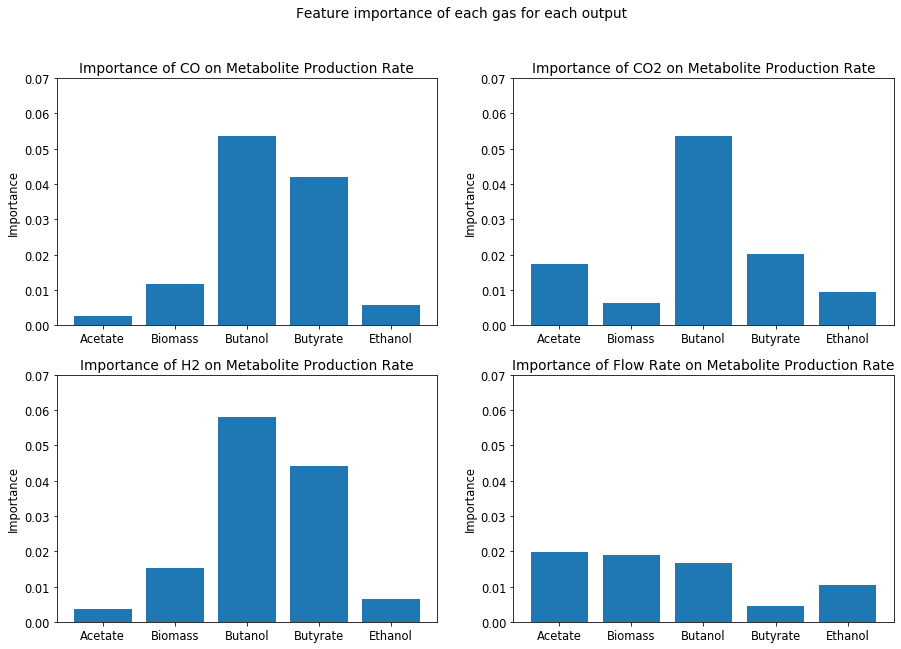

In [16]:
display(gases_feature_importance_df)

plt.rcParams.update({'font.size': 11.5})
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f'Feature importance of each gas for each output')

labels = [label.capitalize() for label in gases_feature_importance_df.index]

ax[0,0].title.set_text(f'Importance of CO on Metabolite Production Rate')
ax[0,0].set_ylabel(f'Importance')
ax[0,0].axis(ymin=0.0,ymax=0.07)
rects = ax[0,0].bar(labels, gases_feature_importance_df['CO'])

ax[0,1].title.set_text(f'Importance of CO2 on Metabolite Production Rate')
ax[0,1].set_ylabel(f'Importance')
ax[0,1].axis(ymin=0.0,ymax=0.07)
rects = ax[0,1].bar(labels, gases_feature_importance_df['CO2'])

ax[1,0].title.set_text(f'Importance of H2 on Metabolite Production Rate')
ax[1,0].set_ylabel(f'Importance')
ax[1,0].axis(ymin=0.0,ymax=0.07)
rects = ax[1,0].bar(labels, gases_feature_importance_df['H2'])

ax[1,1].title.set_text(f'Importance of Flow Rate on Metabolite Production Rate')
ax[1,1].set_ylabel(f'Importance')
ax[1,1].axis(ymin=0.0,ymax=0.07)
rects = ax[1,1].bar(labels, gases_feature_importance_df['flow rate'])

plt.savefig(f'{home_dir}/final_figures/feature_importance_per_gas.png', dpi=100)

plt.show()

### Save gases_feature_importance as csv

In [17]:
gases_feature_importance_df.to_csv('../feature_importance_data/gases_importance.csv')

### -- Stopping here --